In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math

#### 1. Z obou datových souborů načtěte texty k analýze. Pro každý text zvlášť odhadněte pravděpodobnosti znaků (symbolů včetně mezery), které se v textech vyskytují. Výsledné pravděpodobnosti graficky znázorněte. (1b)

In [2]:
# nacteni dat
def read_file(file):
    with open(file) as f:
        lines = f.readlines()
        return lines[1]

dpath = Path('../data')
first = read_file(dpath / 'first-009.txt')
second = read_file(dpath / 'second-005.txt')

In [3]:
# vypocitani cetnosti
def check_freq(x):
    freq = {}
    for c in set(x):
        freq[c] = x.count(c)
    return freq

freq_first = check_freq(first)
freq_second = check_freq(second)

col = ['znak', 'absolutni cetnost']
dfa = pd.DataFrame(freq_first.items(), columns=col)
dfb = pd.DataFrame(freq_second.items(), columns=col)

def comp_rel_freq(*arg):
    for df in arg:
        df['relativni cetnost'] = df['absolutni cetnost'] / df['absolutni cetnost'].sum()
        
comp_rel_freq(dfa, dfb)

# aplha sort
dfa = dfa.sort_values('znak').reset_index(drop=True)
dfb = dfb.sort_values('znak').reset_index(drop=True)
display(dfa.head())
display(dfb.head())

znak  absolutni cetnost  relativni cetnost
0                    1059           0.189887
1    a                366           0.065627
2    b                 65           0.011655
3    c                105           0.018827
4    d                205           0.036758

znak  absolutni cetnost  relativni cetnost
0                    1079           0.199445
1    a                378           0.069871
2    b                 64           0.011830
3    c                 82           0.015157
4    d                218           0.040296

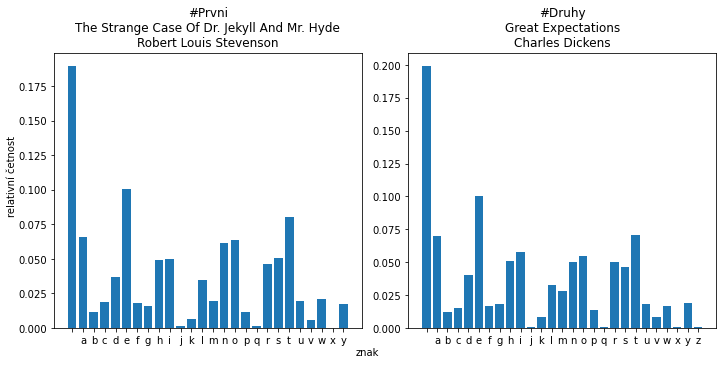

In [4]:
# vizualizace
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs = axs.ravel()
axs[0].bar(dfa['znak'], dfa['relativni cetnost'])
axs[0].set_title('#Prvni\nThe Strange Case Of Dr. Jekyll And Mr. Hyde\nRobert Louis Stevenson')
axs[1].bar(dfb['znak'], dfb['relativni cetnost'])
axs[1].set_title('#Druhy\nGreat Expectations\nCharles Dickens')
fig.tight_layout()
fig.text(0.5, 0.00, 'znak', ha='center')
fig.text(0.00, 0.5, 'relativní četnost', va='center', rotation='vertical');

#### 2.  Pro každý text zvlášť spočtěte entropii odhadnutého rozdělení znaků. (1b)

In [5]:
def comp_entropy(df, base=2):
    H = 0
    for index, row in df.iterrows():
        p = row['relativni cetnost']
        H -= p * math.log(p, base)
    return H

print('Entropie odhadnutého rozdělení znaků')
print(f'První text: {comp_entropy(dfa):.3f}')
print(f'Druhý text: {comp_entropy(dfb):.3f}')

Entropie odhadnutého rozdělení znaků
První text: 4.060
Druhý text: 4.063


#### 3. Nalezněte optimální binární instantní kód C pro kódování znaků prvního z textů. (2b)
<div>
<img src="../img/huffman.png" width="40%"/>
</div>
Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-06-Slides.pdf">https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-06-Slides.pdf</a>, slide 22


Hledáme tedy Huffmanův binární kód pro text The Strange Case Of Dr. Jekyll And Mr. Hyde.

**Postup:** Spojujeme vždy 2 množiny s nejnižší relativní četností. Počáteční množiny jsou samostatné znaky. Až spojíme všechny množiny do 1 množiny (celého universa), zpetně ohodnocujeme potomky -  0 levého, 1 pravého. Ve výsledném kódování se na první pozici nachází ohodnocení vedoucí z kořene stromu a nejdelší kódování mají ty nejméně četné znaky.

In [6]:
class Tree(object):
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right

    def children(self):
        return (self.left, self.right)

def huffman_code_tree(node, left=True, binString=''):
    if type(node) is str:
        return {node: binString}
    (l, r) = node.children()
    d = dict()
    d.update(huffman_code_tree(l, True, binString + '0'))
    d.update(huffman_code_tree(r, False, binString + '1'))
    return d


def construct_tree_for_huffman_coding(df):
    d = dict(zip(df['znak'], df['relativni cetnost']))
    nodes = sorted(d.items(), key=lambda item: item[1], reverse=True)
    
    while len(nodes) > 1:
        (key1, c1) = nodes[-1]
        (key2, c2) = nodes[-2]
        nodes = nodes[:-2]
        node = Tree(key1, key2)
        nodes.append((node, c1 + c2))
        nodes = sorted(nodes, key=lambda x: x[1], reverse=True)
    
    return nodes[0][0]

huffman_code = huffman_code_tree(construct_tree_for_huffman_coding(dfa))

df_huff = pd.DataFrame([(char, huffman_code[char]) for char in dfa.znak.unique()], columns=['znak', 'optimalni kodovani'])
dfa = dfa.merge(df_huff, on=['znak'])

print('Optimalni kodovani Huffmanovym kodem:\n')
display(dfa.sort_values(by=['relativni cetnost'], ascending=False)) # .drop(columns=['absolutni cetnost'])

Optimalni kodovani Huffmanovym kodem:



znak  absolutni cetnost  relativni cetnost optimalni kodovani
0                     1059           0.189887                 00
5     e                561           0.100592                010
20    t                447           0.080151               1101
1     a                366           0.065627               1010
15    o                357           0.064013               1001
14    n                344           0.061682               1000
19    s                284           0.050923               0110
9     i                279           0.050027              11111
8     h                276           0.049489              11110
18    r                260           0.046620              11101
4     d                205           0.036758              11000
12    l                194           0.034786              10110
23    w                118           0.021158             111001
21    u                111           0.019903             111000
13    m                109           0.019545             110011
3     c                105           0.018827             110010
6     f                102           0.018289             101111
25    y                 95           0.017034             101110
7     g                 87           0.015600             011110
16    p                 65           0.011655             011100
2     b                 65           0.011655             011101
11    k                 37           0.006634            0111110
22    v                 34           0.006096           01111111
17    q                  8           0.001434          011111100
10    j                  7           0.001255         0111111011
24    x                  2           0.000359         0111111010

#### 4. Pro každý text zvlášť spočtěte střední délku kódu C a porovnejte ji s entropií rozdělení znaků. Je kód C optimální i pro druhý text? (2b)

Střední délku kódu jsme vypočítali pomocí vzorce:
<img src="../img/avg_code_length_formula.png" width="60%"/>
Zdroj: <a href="https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-06-Slides.pdf">https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-06-Slides.pdf</a>, slide 5

In [7]:
def get_avg_codeword_length(df) :
    avg_codeword_length = 0
    for index, row in dfa.iterrows():
        avg_codeword_length += len(row['optimalni kodovani']) * row['relativni cetnost']
    return avg_codeword_length

print('Střední délka kódu C prvního textu je:', get_avg_codeword_length(dfa))
print('Entropie prvního textu je:', comp_entropy(dfa))

Střední délka kódu C prvního textu je: 4.105791644253182
Entropie prvního textu je: 4.060006550506617


**Je možné pozorovat, že střední délka kódu C prvního textu je větší než jeho entropie rozdělení znaků.**

#### Je kód C optimální i pro druhý text?
**Ne**, kód C není optimální i pro druhý text. Kódování C totiž nelze použít pro zakódování textu 2, jelikož neumí zakódovat znak **z**, který se vyskytuje v textu 2, ale v textu 1 chybí. 

Níže je zobrazeno optimální kódování pro druhý text a porovnána hodnota střední délky tohoto kódování s entropií rozdělení znaků. Je možné vidět, že i u druhého textu je střední délka optimálního kódu větší než hodnota jeho entropie rozdělení znaků.

In [8]:
# ziskani huffmanova kodovani pro druhy text
huffman_code_text_b = huffman_code_tree(construct_tree_for_huffman_coding(dfb))
df_huff_text_b = pd.DataFrame([(char, huffman_code_text_b[char]) for char in dfb.znak.unique()], columns=['znak', 'optimalni kodovani'])
df_huff_text_b = dfb.merge(df_huff_text_b, on=['znak'])

print('Střední délka optimálního kódu druhého textu je:', get_avg_codeword_length(df_huff_text_b))
print('Entropie druhého textu je:', comp_entropy(dfb))
df_huff_text_b[['znak', 'optimalni kodovani']]

Střední délka optimálního kódu druhého textu je: 4.105791644253182
Entropie druhého textu je: 4.0630294692832365


znak optimalni kodovani
0                       00
1     a               1011
2     b            1110010
3     c             100110
4     d              11011
5     e               1111
6     f             101010
7     g             101011
8     h               0110
9     i               1000
10    j        11100010111
11    k            1110000
12    l              10100
13    m              10010
14    n               0100
15    o               0111
16    p            1110011
17    q         1110001010
18    r               0101
19    s              11101
20    t               1100
21    u             110100
22    v           11100011
23    w             100111
24    x          111000100
25    y             110101
26    z        11100010110